# Complementaria Semana 8: Simulación de un Proceso de Poisson

En esta complementaria modelaremos la ocurrencia de eventos en el tiempo usando un **Proceso de Poisson**, un modelo clásico para llegadas aleatorias (clientes a una fila, llamadas, fallas, mensajes, etc.).

Un proceso de Poisson con tasa $\lambda>0$ se denota $N(t)$ y representa el **número de eventos** ocurridos hasta el tiempo $t$.


### Objetivos

Al final de esta guía podrás:

1. Simular un Proceso de Poisson usando tiempos entre eventos.
2. Verificar empíricamente que los tiempos entre eventos son exponenciales.
3. Verificar empíricamente que $N(t)\sim \text{Poisson}(\lambda t)$.
4. Aplicar **superposición** (sumar procesos) y **división/thinning** (filtrar eventos).
5. Estimar momentos y probabilidades relevantes (medias, varianzas, $P(N(t)\ge k)$, etc.).


### Librerías que usaremos
- `numpy` para muestreo y cálculo numérico
- `matplotlib` para visualización
- `scipy.stats` para comparaciones y tests


Si aún no están instaladas en el entorno, utilizar este comando en una celda de python:

In [1]:
pip install numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Posteriormente, importar las librerías:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# Proceso de Poisson

Recordemos que un proceso de Poisson $N(t)$ con tasa $\lambda>0$ representa el **número de eventos** ocurridos hasta el tiempo $t$. 

Si definimos los tiempos entre eventos como:

$$
T_1, T_2, \dots
$$

entonces en un proceso de Poisson:

$$
T_i \overset{iid}{\sim} \text{Exp}(\lambda)
$$

y los tiempos de eventos (tiempos de llegadas/arribos) se construyen como:

$$
S_n = \sum_{i=1}^n T_i
$$


## ¿Cómo lo simulamos?

1. Generar tiempos entre eventos $T_i \sim \text{Exp}(\lambda)$.
2. Acumularlos: $S_n = T_1 + \cdots + T_n$.
3. Los eventos ocurren en los tiempos $S_1, S_2, \dots$ hasta superar un horizonte $T$.

<br>

---


# Simulación de una trayectoria de un Proceso de Poisson

Simularemos una trayectoria de $N(t)$ en el intervalo $[0, T)$.

**Parámetros:**
- tasa $\lambda$
- horizonte de simulación $T$

**Salida:**
- lista de tiempos de eventos $(S_1, S_2, ...)$
- proceso de conteo $N(t)$ como función escalonada


In [4]:
def simulate_poisson_process(lambda_rate, T, rng):
    """
    Simula un Proceso de Poisson con tasa lambda_rate en [0, T) usando tiempos entre llegadas Exp(lambda).
    Retorna: array con tiempos de eventos (llegadas) <= T.
    """
    t = 0.0
    arrivals = []
    while True:
        # interevento ~ Exp(lambda): T = -ln(U)/lambda
        u = rng.random()
        inter = -np.log(u) / lambda_rate
        t += inter
        if t > T:
            break
        arrivals.append(t)
    return np.array(arrivals)


In [5]:
# Simulación de un Proceso de Poisson
lambda_rate = 2
T = 10
rng = np.random.default_rng(0)

arrivals = simulate_poisson_process(lambda_rate, T, rng)

print("Tiempo de eventos:", arrivals)
print("Número de eventos N(T):", len(arrivals))

Tiempo de eventos: [0.22552289 0.88058468 2.47799927 4.52935997 4.63270589 4.67834946
 4.92826282 5.08596313 5.39071094 5.42427659 5.52603679 8.47620924
 8.55313211]
Número de eventos N(T): 13


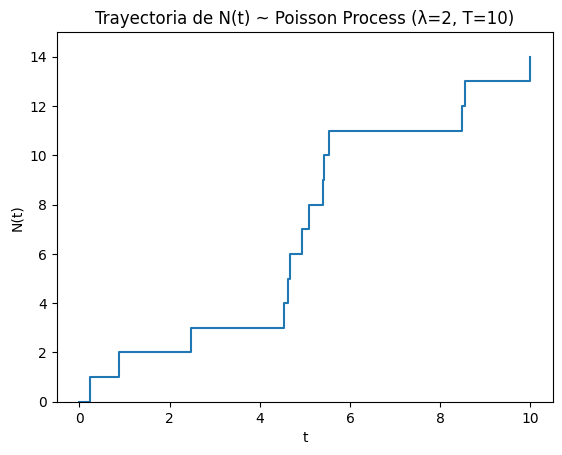

Número total de eventos N(T): 13


In [6]:
# Construimos la trayectoria escalonada de N(t)
times = np.concatenate(([0.0], arrivals, [T]))
counts = np.arange(len(times))  # N(t) sube 1 en cada evento

plt.figure()
plt.step(times, counts, where="post")
plt.title(f"Trayectoria de N(t) ~ Poisson Process (λ={lambda_rate}, T={T})")
plt.xlabel("t")
plt.ylabel("N(t)")
plt.ylim(0, counts[-1] + 1)
plt.show()

print("Número total de eventos N(T):", len(arrivals))


# Ejemplo guiado 1 — Verificar que los tiempos entre eventos son Exponenciales

Si $N(t)$ es un proceso de Poisson con tasa $\lambda$, entonces los tiempos entre eventos $T_i$ son exponenciales iid:

$$
T_i \sim \text{Exp}(\lambda)
$$

Validaremos empíricamente esto generando muchos tiempos entre eventos y comparando:

- histograma vs pdf exponencial
- media y varianza empírica vs teórica
- test Kolmogorov-Smirnov (opcional)


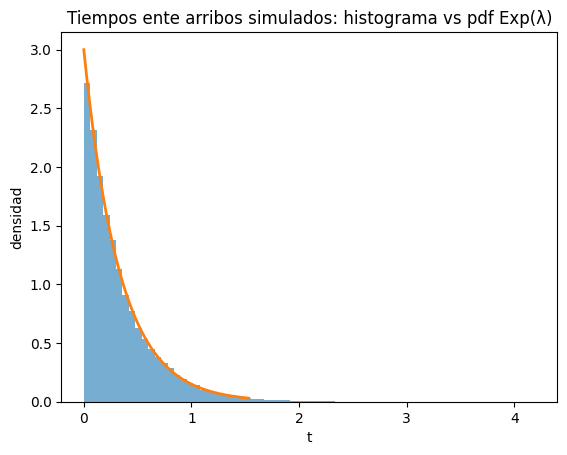

In [ ]:
lambda_rate = 3.0
n = 100_000

# Simulación de tiempos entre llegadas con transformada inversa
U = rng.random(n)
interarrivals = -np.log(U) / lambda_rate

# Histograma + pdf teórica
plt.figure()
plt.hist(interarrivals, bins=70, density=True, alpha=0.6)

xgrid = np.linspace(0, np.quantile(interarrivals, 0.9999), 400)
pdf = lambda_rate * np.exp(-lambda_rate * xgrid)
plt.plot(xgrid, pdf, linewidth=2)

plt.title("Tiempos ente arribos simulados: histograma vs pdf Exp(λ)")
plt.xlabel("t")
plt.ylabel("densidad")
plt.show()


In [8]:
# Comparación de media y varianza empírica vs teórica
print("Media empírica:", interarrivals.mean(), "| Teórica:", 1/lambda_rate)
print("Var  empírica:", interarrivals.var(ddof=1), "| Teórica:", 1/(lambda_rate**2))


Media empírica: 0.33350822062474755 | Teórica: 0.3333333333333333
Var  empírica: 0.11062649867596967 | Teórica: 0.1111111111111111


In [ ]:
# KS test (opcional)
D, p = stats.kstest(interarrivals, "expon", args=(0, 1/lambda_rate))  # scale=1/lambda
print("KS statistic:", D)
print("p-value     :", p)


KS statistic: 0.0025904071050598665
p-value     : 0.5124721029910152


# Ejemplo guiado 2 — Verificar que $N(T)\sim \text{Poisson}(\lambda T)$

Teóricamente, el número de eventos en un horizonte $T$ cumple:

$$
N(T) \sim \text{Poisson}(\lambda T)
$$

Validaremos esto repitiendo muchas simulaciones independientes, guardando los valores de $N(T)$
y comparando con la distribución de Poisson teórica.


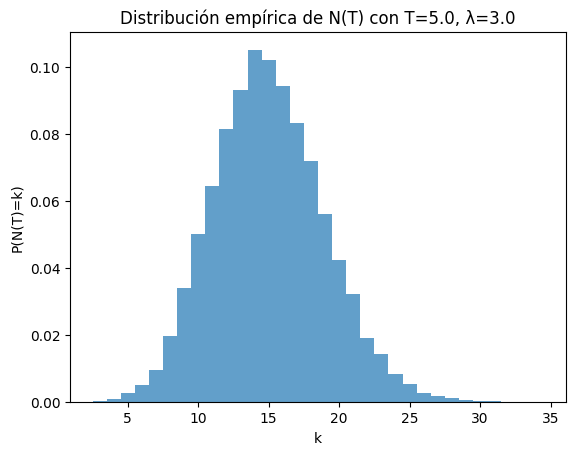

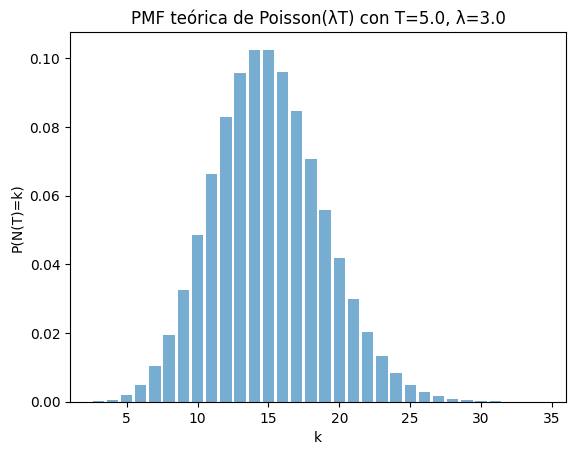

In [11]:
lambda_rate = 3.0
T = 5.0
R = 20_000  # repeticiones

NT = np.empty(R, dtype=int)
for r in range(R):
    arrivals = simulate_poisson_process(lambda_rate, T, rng)
    NT[r] = len(arrivals)

# Histograma discreto
plt.figure()
plt.hist(NT, bins=np.arange(NT.min(), NT.max()+2)-0.5, density=True, alpha=0.7)
plt.title(f"Distribución empírica de N(T) con T={T}, λ={lambda_rate}")
plt.xlabel("k")
plt.ylabel("P(N(T)=k)")
plt.show()


# comparación visual con pmf de Poisson
k_vals = np.arange(NT.min(), NT.max()+1)
pmf = stats.poisson.pmf(k_vals, mu=lambda_rate*T)
plt.figure()
plt.bar(k_vals, pmf, alpha=0.6)
plt.title(f"PMF teórica de Poisson(λT) con T={T}, λ={lambda_rate}")
plt.xlabel("k")
plt.ylabel("P(N(T)=k)")
plt.show()

In [12]:
# Comparación de media y varianza empírica vs teórica
print("E[N(T)] empírica:", NT.mean(), "| Teórica:", lambda_rate*T)
print("Var[N(T)] empírica:", NT.var(ddof=1), "| Teórica:", lambda_rate*T)

E[N(T)] empírica: 15.01645 | Teórica: 15.0
Var[N(T)] empírica: 15.23494114455723 | Teórica: 15.0


# Superposición y división (thinning)

## (A) Superposición (suma)

Si:
- $N_1(t)$ es Poisson con tasa $\lambda_1$
- $N_2(t)$ es Poisson con tasa $\lambda_2$
- y son independientes,

entonces:

$$
N(t) = N_1(t) + N_2(t)
$$

es un proceso de Poisson con tasa:

$$
\lambda = \lambda_1 + \lambda_2
$$


E[N1(T)+N2(T)] emp: 28.0206 | Teórica: 28.0
Var emp: 27.502125852585266 | Teórica: 28.0


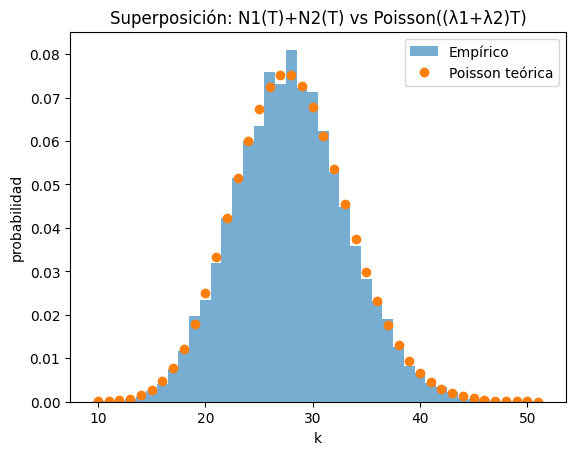

In [13]:
# Superposición: simular dos procesos y sumar N(T)
lambda1 = 2.0
lambda2 = 5.0
T = 4.0
R = 10_000

NT_sum = np.empty(R, dtype=int)
for r in range(R):
    a1 = simulate_poisson_process(lambda1, T, rng)
    a2 = simulate_poisson_process(lambda2, T, rng)
    NT_sum[r] = len(a1) + len(a2)

print("E[N1(T)+N2(T)] emp:", NT_sum.mean(), "| Teórica:", (lambda1+lambda2)*T)
print("Var emp:", NT_sum.var(ddof=1), "| Teórica:", (lambda1+lambda2)*T)

# comparar con Poisson((λ1+λ2)T)
mu = (lambda1 + lambda2) * T
k_vals = np.arange(NT_sum.min(), NT_sum.max()+1)
pmf = stats.poisson.pmf(k_vals, mu=mu)

plt.figure()
plt.hist(NT_sum, bins=np.arange(NT_sum.min(), NT_sum.max()+2)-0.5, density=True, alpha=0.6, label="Empírico")
plt.plot(k_vals, pmf, marker="o", linestyle="", label="Poisson teórica")
plt.title("Superposición: N1(T)+N2(T) vs Poisson((λ1+λ2)T)")
plt.xlabel("k")
plt.ylabel("probabilidad")
plt.legend()
plt.show()



## (B) División / Thinning

Si $N(t)$ es un proceso de Poisson con tasa $\lambda$ y cada evento se clasifica como "tipo A" con probabilidad $p$
(independientemente de todo lo demás), entonces los eventos tipo A forman un proceso de Poisson con tasa:

$$
\lambda_A = p\lambda
$$

y los tipo B con tasa:

$$
\lambda_B = (1-p)\lambda
$$

In [14]:
# División: clasificar eventos en A/B
lambda_rate = 6.0
p = 0.3
T = 5.0
R = 12_000

NA = np.empty(R, dtype=int)
NB = np.empty(R, dtype=int)

for r in range(R):
    arrivals = simulate_poisson_process(lambda_rate, T, rng)
    m = len(arrivals)

    # Clasificar cada evento: A con prob p, B con prob 1-p
    types_A = rng.random(m) < p

    NA[r] = types_A.sum()
    NB[r] = m - NA[r]

print("E[NA] emp:", NA.mean(), "| Teórica:", p*lambda_rate*T)
print("E[NB] emp:", NB.mean(), "| Teórica:", (1-p)*lambda_rate*T)

print("Var[NA] emp:", NA.var(ddof=1), "| Teórica:", p*lambda_rate*T)
print("Var[NB] emp:", NB.var(ddof=1), "| Teórica:", (1-p)*lambda_rate*T)


E[NA] emp: 8.967166666666667 | Teórica: 9.0
E[NB] emp: 20.987083333333334 | Teórica: 20.999999999999996
Var[NA] emp: 9.076345000972303 | Teórica: 9.0
Var[NB] emp: 21.09367429924716 | Teórica: 20.999999999999996


---

# Ejercicio aplicado — Centro de atención con dos tipos de llamadas

Un centro de atención recibe llamadas según un Proceso de Poisson con tasa $\lambda=8$ (llamadas por hora).

Cada llamada se clasifica como:
- **Soporte** con probabilidad $p=0.65$
- **Ventas** con probabilidad $1-p=0.35$

Asumimos que la clasificación es independiente entre llamadas.

## Parte A — Conteos en una hora

1. Simula $R=50\,000$ horas de operación y estima empíricamente:
   - $\mathbb{E}[N(1)]$ y $\mathrm{Var}(N(1))$
   - $P(N(1)\ge 12)$

2. Compara con los valores teóricos usando $N(1)\sim \text{Poisson}(\lambda)$.


In [18]:
lambda_rate = 8.0
p = 0.65
R = 50_000
T_hour = 1.0

# Simular N(1) usando Poisson(λ*1) directamente (equivalente a simular llegadas)
N1 = rng.poisson(lam=lambda_rate*T_hour, size=R)

print("Parte A")
print("E[N(1)] emp:", N1.mean(), "| Teórica:", lambda_rate*T_hour)
print("Var emp:", N1.var(ddof=1), "| Teórica:", lambda_rate*T_hour)
print("P(N(1) >= 12) emp:", np.sum(N1 >= 12)/R)

print("P(N(1) >= 12) teo:", 1 - stats.poisson.cdf(11, mu=lambda_rate*T_hour))

Parte A
E[N(1)] emp: 8.0101 | Teórica: 8.0
Var emp: 7.9948778875577515 | Teórica: 8.0
P(N(1) >= 12) emp: 0.11258
P(N(1) >= 12) teo: 0.11192400101851863


## Parte B — División (thinning) por tipo

3. Para cada hora simulada, clasifica llamadas en Soporte y Ventas y estima:
   - $\mathbb{E}[N_S(1)]$, $\mathbb{E}[N_V(1)]$
   - $P(N_S(1)=0)$ y $P(N_V(1)\ge 5)$

4. Compara con teoría usando:
   - $N_S(1)\sim \text{Poisson}(p\lambda)$
   - $N_V(1)\sim \text{Poisson}((1-p)\lambda)$


In [20]:
# Para cada hora con N llamadas, el número de soporte ~ Binomial(N, p)
NS = rng.binomial(N1, p)
NV = N1 - NS

print("\nParte B")
print("E[NS] emp:", NS.mean(), "| Teórica:", p*lambda_rate*T_hour)
print("E[NV] emp:", NV.mean(), "| Teórica:", (1-p)*lambda_rate*T_hour)

print("P(NS=0) emp:", np.sum(NS == 0)/R)
print("P(NV>=5) emp:", np.sum(NV >= 5)/R)

print("P(NS=0) teo:", stats.poisson.pmf(0, mu=p*lambda_rate*T_hour))
print("P(NV>=5) teo:", 1 - stats.poisson.cdf(4, mu=(1-p)*lambda_rate*T_hour))


Parte B
E[NS] emp: 5.20116 | Teórica: 5.2
E[NV] emp: 2.80894 | Teórica: 2.8
P(NS=0) emp: 0.00542
P(NV>=5) emp: 0.15396
P(NS=0) teo: 0.0055165644207607716
P(NV>=5) teo: 0.1523239430211616


## Parte C — Tiempos entre llamadas (interarribos)

5. En una simulación larga (por ejemplo $T=200$ horas), recolecta interarribos y verifica:
   - histograma vs pdf de $\text{Exp}(\lambda)$
   - media empírica vs teórica $1/\lambda$


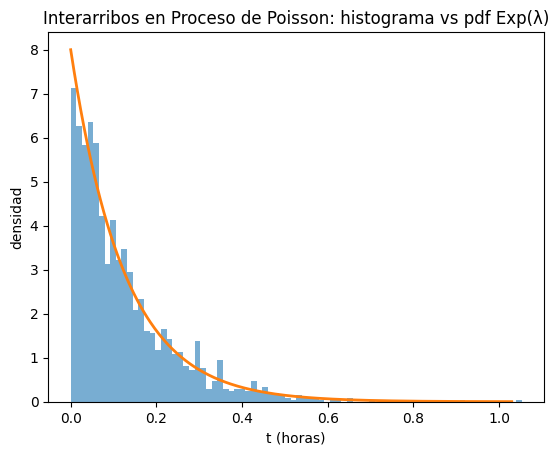

Media empírica interarribos: 0.1249044337492507 | Teórica: 0.125


In [22]:
lambda_rate = 8.0
T_long = 200.0

arrivals = simulate_poisson_process(lambda_rate, T_long, rng)

# Interarribos: diferencias entre llegadas consecutivas
interarrivals = np.diff(np.concatenate(([0.0], arrivals)))

plt.figure()
plt.hist(interarrivals, bins=80, density=True, alpha=0.6)

xgrid = np.linspace(0, np.quantile(interarrivals, 0.9999), 400)
pdf = lambda_rate * np.exp(-lambda_rate * xgrid)
plt.plot(xgrid, pdf, linewidth=2)

plt.title("Interarribos en Proceso de Poisson: histograma vs pdf Exp(λ)")
plt.xlabel("t (horas)")
plt.ylabel("densidad")
plt.show()

print("Media empírica interarribos:", interarrivals.mean(), "| Teórica:", 1/lambda_rate)
